<img src="Imagenes/preparacion_datasett.jpg" alt="Imagen creada con inteligencia artificial y editada con Microsoft Paint" style="border-radius: 15px">


*Imagen creada con inteligencia artificial.*


## **INTRODUCCIÓN**

Como se ha visto en el EDA del dataset, no todas las etiquetas, es decir, las expresiones, están igualmente representadas. Por ejemplo, la etiqueta 3 (Felicidad) tiene 8989 entradas, mientras que la etiqueta 1 (Asco) tiene tan solo 547 entradas.

Pese a que 547 podría parecer "no pocas" entradas, este desbalanceo puede suponer una merma importante en la calidad de un modelo. Lo ideal sería aumentar el dataset con más fotografías, pero esto es tedioso, lleva tiempo y no es lo más práctico.

La opción que aquí se muestra es crear fotografías nuevas a partir de las ya existentes, volteándolas horizontalmente, añadiendo algo de ruido y aumentando o disminuyendo el brillo. De esta forma, y haciéndolo solo a las clases/emociones más subrepresentadas, podemos conseguir un nuevo dataset algo más balanceado.

> Este notebook puede parecer algo complicado, al final hay un resumen y explicación.
>> Durante todo el notebook hay explicaciones.
> 
> Sí, efectivamente, la imagen del banner es un guiño al hecho de que aquí se arreglan fotos.
> 
> Al final del notebook hay un resumen/explicación.


## **BIBLIOTECAS USADAS:**

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import ast  
from scipy.ndimage import rotate

## **CARGA DEL DASET**

In [2]:
df = pd.read_csv('./datos/fer2013/fer2013.csv')

## **FLIP HORIZONTAL**

>Después del proceso de **data augmentation**, todas las clases tendrán la misma cantidad de **fotografías** (arrays en verdad).    
>Igualaremos el número de fotografías a la clase que más tiene, que es la **clase 3**. A la clase 3 no le haremos nada.    
>Para las demás clases, haremos distintos procesos hasta que igualen a la clase 3.  
>El primer proceso será un "flip horizontal.  


In [3]:
def seleccionar_aleatoriamente(df, emotion, n):
    return df[df['emotion'] == emotion].sample(n=n, random_state=42)
df_emotion_6 = seleccionar_aleatoriamente(df, 6, 2791)
df_emotion_4 = seleccionar_aleatoriamente(df, 4, 2912)
df_emotion_2 = seleccionar_aleatoriamente(df, 2, 3868)
df_emotion_0 = seleccionar_aleatoriamente(df, 0, 4036)
df_emotion_5 = df[df['emotion'] == 5]
df_emotion_1 = df[df['emotion'] == 1]
df_espejo = pd.concat([df_emotion_6, df_emotion_4, df_emotion_2, df_emotion_0, df_emotion_5, df_emotion_1])
df_espejo = df_espejo.reset_index(drop=True) 
df_sin_espejo = df_espejo.copy() #Solo para comparar después

>Haremos **"flip"** a tantas entradas,lineas, por etiqueta de expresión facial como sea necesario para igualar la clase **"3"**.
>
>Las clases **"1"** y **"5"** necesitan otros procesos para poder tener suficiente cantidad.


In [4]:
def flip_image_horizontal(pixel_string):
    try:
        pixel_values = list(map(int, pixel_string.split()))
        size = int(np.sqrt(len(pixel_values)))
        image_matrix = np.array(pixel_values).reshape((size, size))
        flipped_image_matrix = np.fliplr(image_matrix)
        flipped_pixel_string = ' '.join(map(str, flipped_image_matrix.flatten()))
        return flipped_pixel_string
    except Exception as e:
        print(f"Error al procesar la imagen: {e}")
        return pixel_string  # Devuelve la cadena original en caso de error
df_espejo.loc[:, 'pixels'] = df_espejo['pixels'].apply(lambda x: flip_image_horizontal(x))


### **Visualizamos primero sin voltear y luego volteado, para ver si se ha realizado correctamente.**


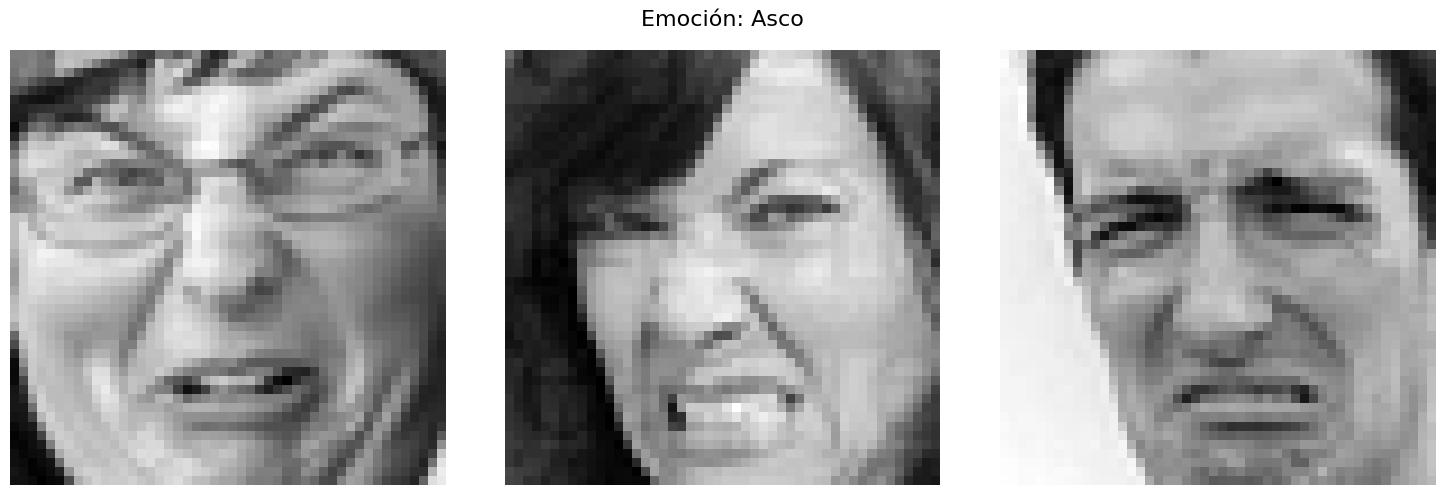

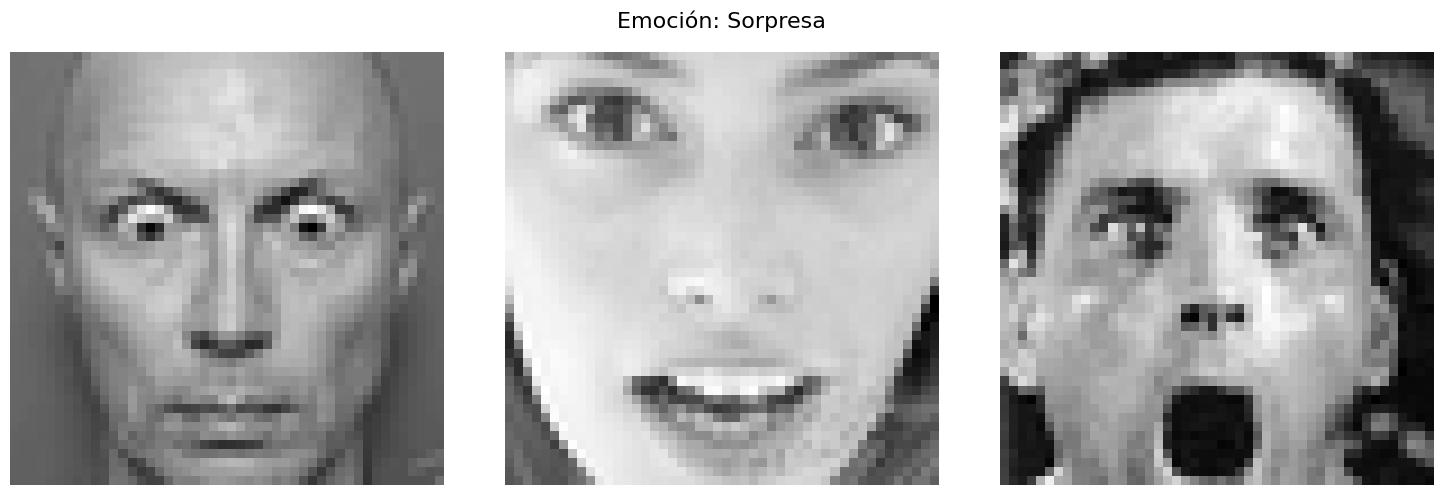

In [5]:
emotion_labels = {1: 'Asco', 5: 'Sorpresa'} #No es necesario visualizar todas las clases para ver que ha ido bien.
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [1, 5]:
    mostrar_imagenes_emocion(df_sin_espejo, emotion)


### **Ahora volteado.**

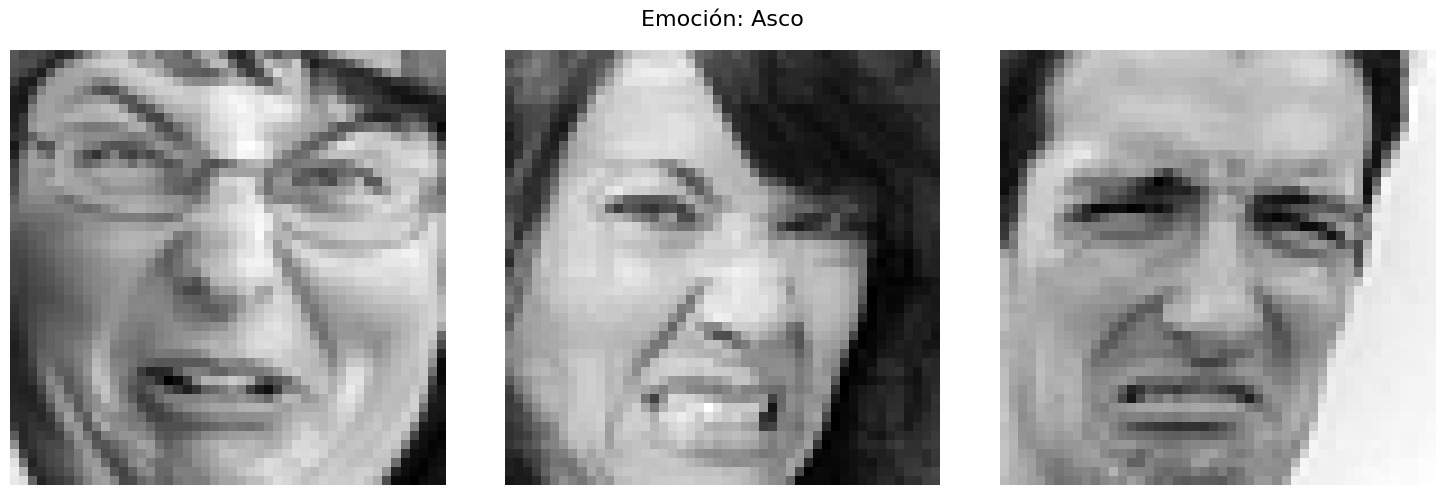

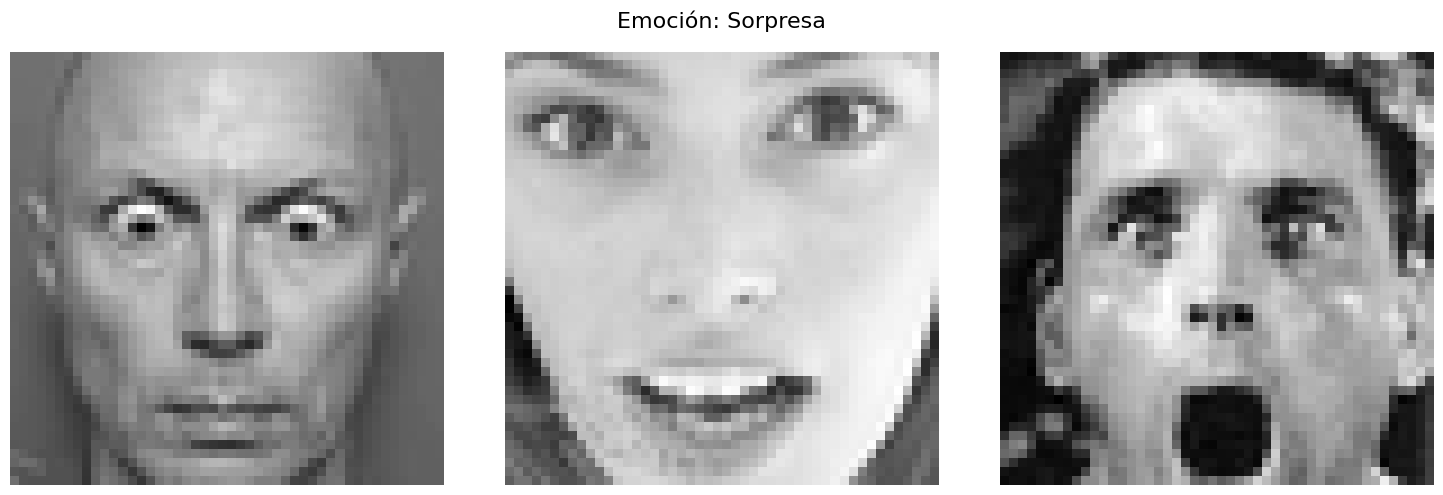

In [6]:
for emotion in [ 1, 5]:
    mostrar_imagenes_emocion(df_espejo, emotion)


### **"EL VOLTEO HORIZONTAL HA SIDO TODO UN ÉXITO, PODEMOS UNIR LOS DATAFRAMES!"**


In [7]:
df_con_volteo = pd.concat([df, df_espejo], ignore_index=True)

In [8]:
print("Antes de añadir las fotos volteadas horizontalmente:")
print(df['emotion'].value_counts())
print()
print("Despues de añadir las fotos:")
print(df_con_volteo['emotion'].value_counts())

Antes de añadir las fotos volteadas horizontalmente:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Despues de añadir las fotos:
emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8004
1    1094
Name: count, dtype: int64


>VEMOS QUE HA IDO MUY BIEN, ESTÁ PRÁCTICAMENTE BALANCEADO, A FALTA DE DOS CLASES.


## **AÑADIDO DE RUIDO**  

>Se lo haremos primero solo a la emoción 1, a todas las entradas.


In [9]:
df_ruido_01 = df_con_volteo[df_con_volteo['emotion'] == 1] 
df_sin_ruido_01 = df_con_volteo[df_con_volteo['emotion'] == 1] 

In [10]:
def add_gaussian_noise(image_str, var=0.1):
    image_list = list(map(int, image_str.split()))
    size = int(len(image_list) ** 0.5)  
    image_array = np.array(image_list).reshape((size, size))
    mean = 0
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (size, size))
    noisy = np.clip(image_array + gauss * 70, 0, 255).astype(np.uint8)
    noisy_list = noisy.flatten().tolist()
    return ' '.join(map(str, noisy_list))  
df_ruido_01.loc[:, 'pixels'] = df_ruido_01['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.01))

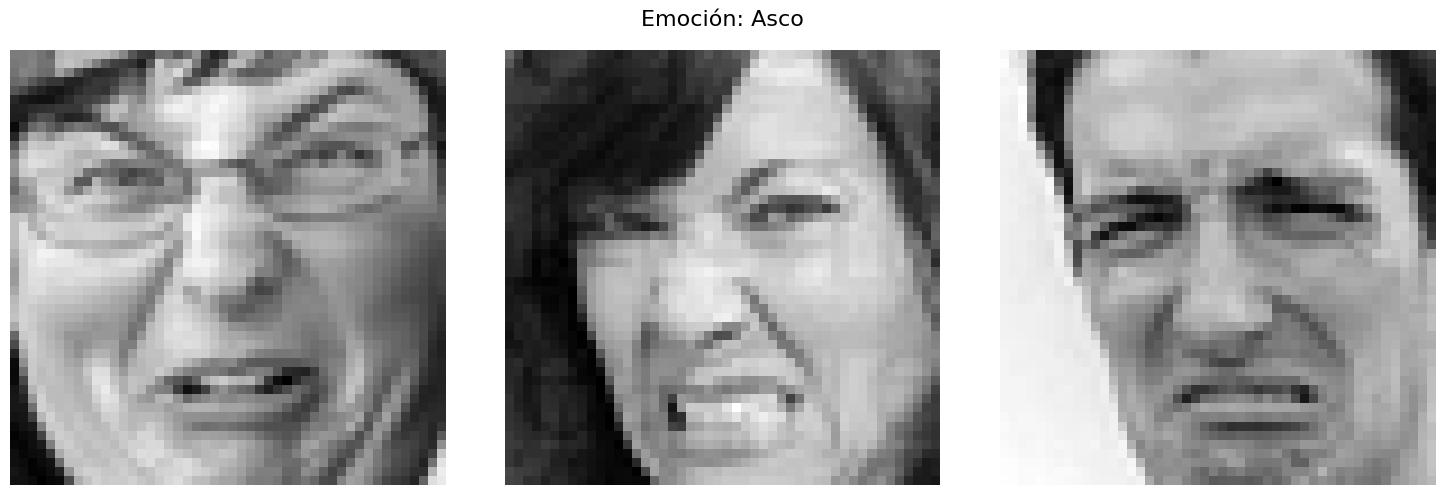

In [11]:
emotion_labels = {1: 'Asco'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [1]:
    mostrar_imagenes_emocion(df_sin_ruido_01, emotion)

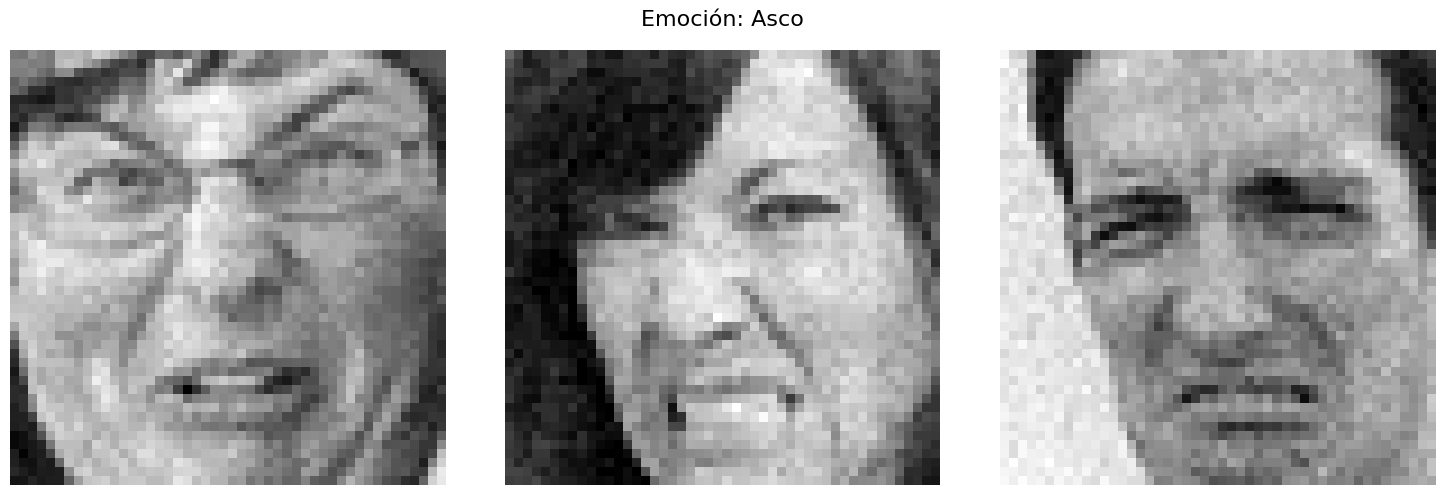

In [12]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_ruido_01, emotion)

> Vemos que ha ido bien.

## **LO HACEMOS AHORA A LA CLASE "5".**
>Solo a 985 líneas, elegidas al azar, para que quede balanceada.

In [13]:
df_emotion_5 = df_con_volteo[df_con_volteo['emotion'] == 5]

df_ruido_05 = df_emotion_5.sample(n=985, random_state=42) 
df_sin_ruido_05= df_ruido_05.copy()


In [14]:
def add_gaussian_noise(image_str, var=0.1):
    image_list = list(map(int, image_str.split()))
    size = int(len(image_list) ** 0.5)  
    image_array = np.array(image_list).reshape((size, size))
    mean = 0
    sigma = var ** 0.5
    gauss = np.random.normal(mean, sigma, (size, size))
    noisy = np.clip(image_array + gauss * 70, 0, 255).astype(np.uint8)
    noisy_list = noisy.flatten().tolist()
    return ' '.join(map(str, noisy_list))  
df_ruido_05.loc[:, 'pixels'] = df_ruido_05['pixels'].apply(lambda x: add_gaussian_noise(x, var=0.01))

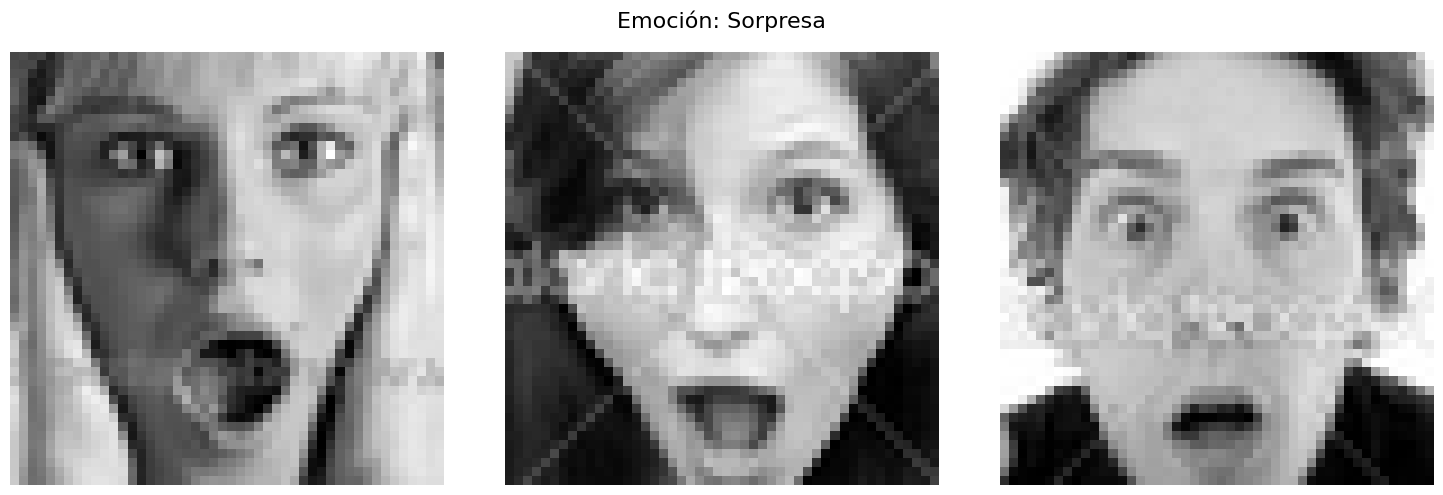

In [15]:
emotion_labels = {5: 'Sorpresa'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [5]:
    mostrar_imagenes_emocion(df_sin_ruido_05, emotion)

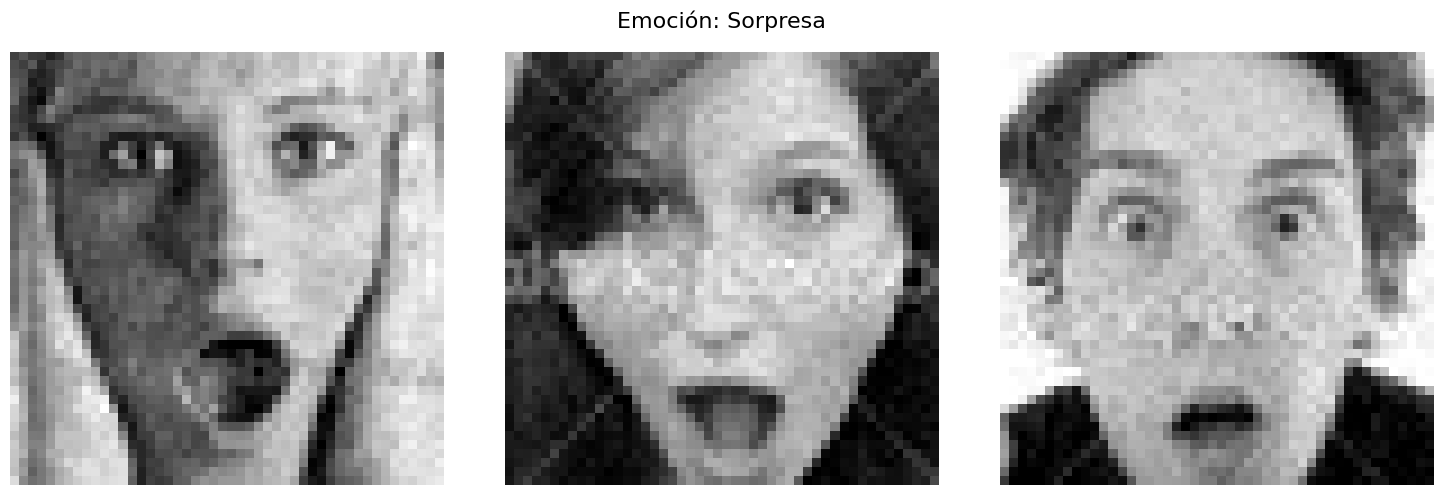

In [16]:
emotion_labels = {5: 'Sorpresa'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [5]:
    mostrar_imagenes_emocion(df_ruido_05, emotion)

In [17]:
df_con_volteo_ruido = pd.concat([df_con_volteo, df_ruido_01, df_ruido_05], ignore_index=True) 


In [18]:
print("El dataframe tal cual viene:")
print(df['emotion'].value_counts())
print()
print("Después del volteo y el ruido:")
print(df_con_volteo_ruido['emotion'].value_counts())

El dataframe tal cual viene:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Después del volteo y el ruido:
emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    2188
Name: count, dtype: int64


>Vemos que, si queremos que esté totalmente balanceado, la clase 1 necesita más trabajo.


## **ROTACIONES**

In [19]:
df_sin_rotaciones = df_con_volteo_ruido[df_con_volteo_ruido['emotion'] == 1]  #Con esto compararemos. 
df_rotaciones_meno10 = df_con_volteo_ruido[df_con_volteo_ruido['emotion'] == 1] 
df_rotaciones_meno5 = df_con_volteo_ruido[df_con_volteo_ruido['emotion'] == 1]
df_rotaciones_mas15 = df_con_volteo_ruido[df_con_volteo_ruido['emotion'] == 1] 
df_rotaciones_mas5 = df_con_volteo_ruido[df_con_volteo_ruido['emotion'] == 1] 


#Esto lo hacemos para no pasarnos.
total_filas = len(df_rotaciones_mas5)
filas_a_mantener = np.random.choice(total_filas, size=237, replace=False)
df_rotaciones_mas5 = df_rotaciones_mas5.iloc[filas_a_mantener]




In [20]:

def rotate_image(image_str, angle):
    image = np.array(image_str.split(), dtype=np.uint8)
    image = image.reshape((48, 48))  # Asumiendo imágenes de 48x48 píxeles
    rotated_image = rotate(image, angle, reshape=False, mode='nearest')
    rotated_image_str = ' '.join(rotated_image.astype(str).flatten())
    return rotated_image_str

df_rotaciones_meno10.loc[:, 'pixels'] = df_rotaciones_meno10['pixels'].apply(lambda x: rotate_image(x, -10))
df_rotaciones_meno5.loc[:, 'pixels'] = df_rotaciones_meno5['pixels'].apply(lambda x: rotate_image(x, -5))
df_rotaciones_mas15.loc[:, 'pixels'] = df_rotaciones_mas15['pixels'].apply(lambda x: rotate_image(x, 15))
df_rotaciones_mas5.loc[:, 'pixels'] = df_rotaciones_mas5['pixels'].apply(lambda x: rotate_image(x, 15))


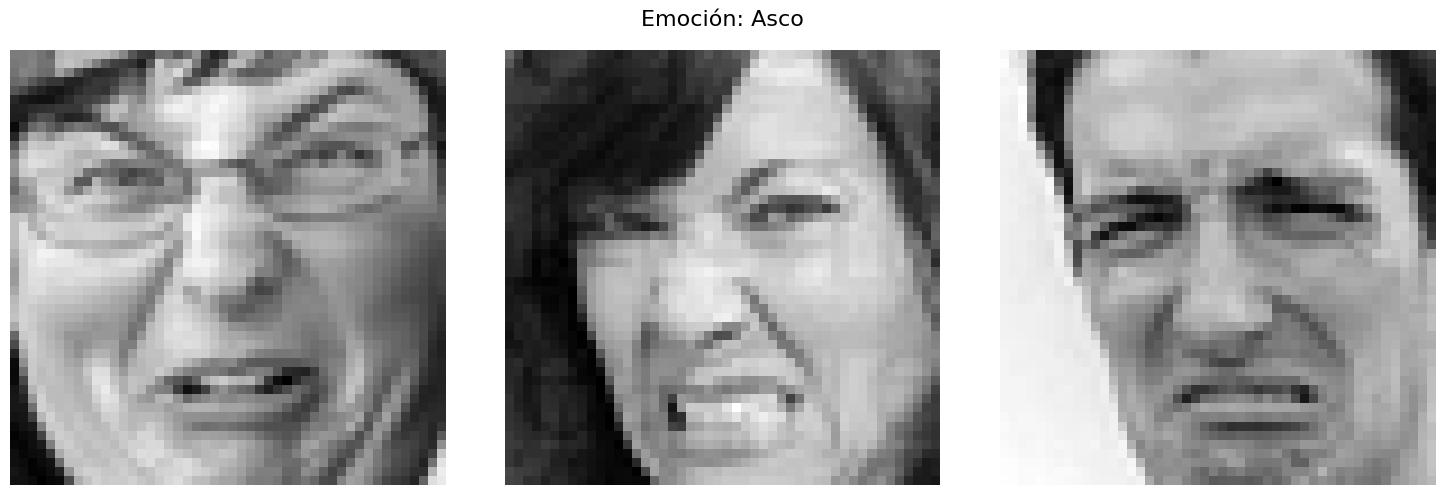

In [21]:
emotion_labels = {1: 'Asco'}
def mostrar_imagenes_emocion(df, emotion):
    filtered_df = df[df['emotion'] == emotion].head(3)  
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(f'Emoción: {emotion_labels[emotion]}', fontsize=16)  
    for i, ax in enumerate(axes):
        if i < len(filtered_df):
            pixels = np.array(filtered_df.iloc[i]['pixels'].split(), dtype='int').reshape(48, 48)
            ax.imshow(pixels, cmap='gray')
            ax.axis('off')   
    plt.tight_layout()
    plt.show()

for emotion in [1]:
    mostrar_imagenes_emocion(df_sin_rotaciones, emotion)

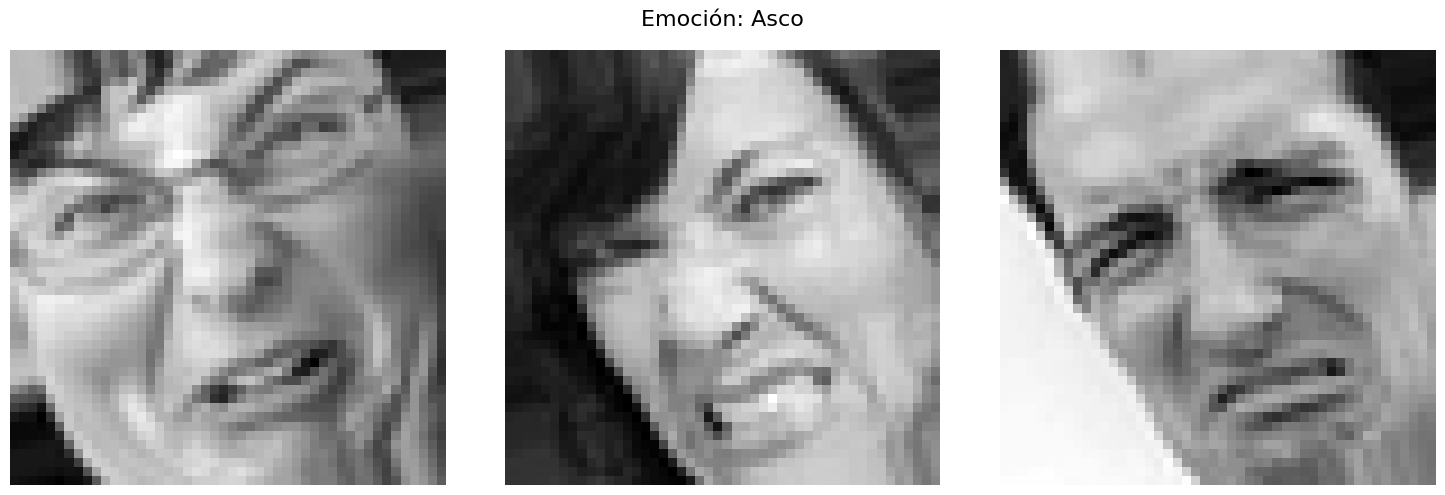

In [22]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_rotaciones_mas15, emotion)

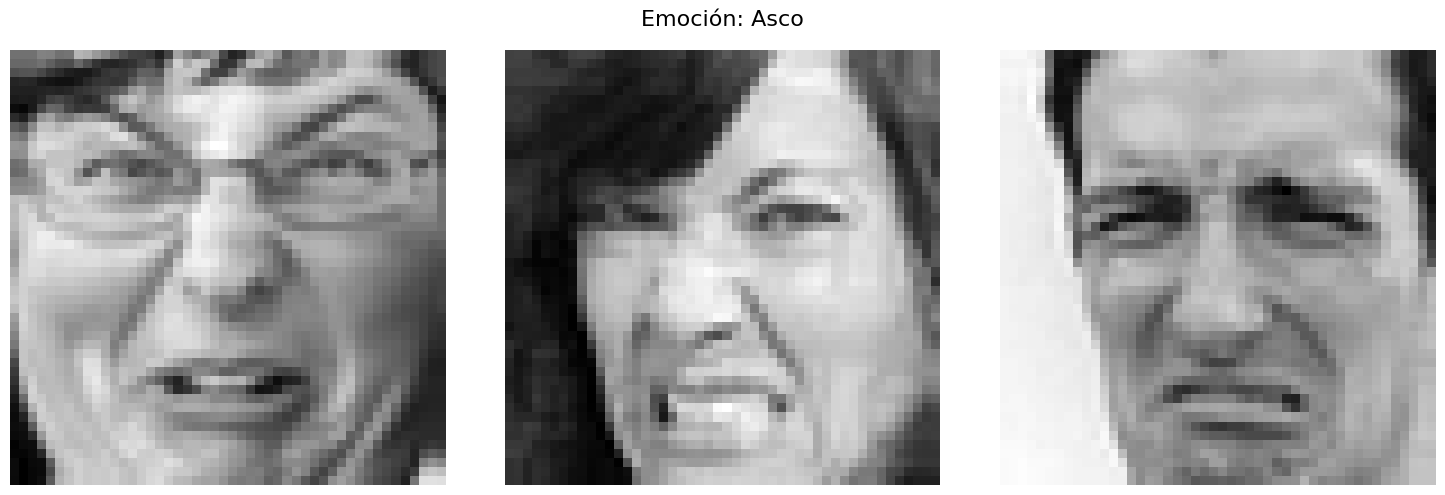

In [23]:
for emotion in [1]:
    mostrar_imagenes_emocion(df_rotaciones_meno5, emotion)

In [24]:
df_con_volteo_ruido_rotaciones = pd.concat([df_con_volteo_ruido, df_rotaciones_meno10, df_rotaciones_meno5, df_rotaciones_mas15, df_rotaciones_mas5 ], ignore_index=True) 

In [25]:
print("El dataframe tal cual viene:")
print(df['emotion'].value_counts())
print()
print("Despues del volteo, el ruido y las rotaciones:")
print(df_con_volteo_ruido_rotaciones['emotion'].value_counts())

El dataframe tal cual viene:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

Despues del volteo, el ruido y las rotaciones:
emotion
0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: count, dtype: int64


In [26]:
df_con_volteo_ruido_rotaciones.to_csv('./datos/fer2013/fer2013_blc.csv', index=False)

## **EXTRA.**  
>**Ya tenemos el dataset balanceado, aumentando las clases subrepresentadas, pero si a este dataset le añadimos el mismo con una pequeña rotación, la precisión aumenta considerablemente. La parte negativa es que el tiempo de entrenamiento también aumenta considerablemente. Guardaremos el modelo entrenado para hacer las predicciones desde este modelo ya entrenado, por lo que el entrenamiento se hará solo una vez. Merece la pena.**

In [27]:
df_balanceado= df_con_volteo_ruido_rotaciones.copy() 
df_balanceado_rototado= df_con_volteo_ruido_rotaciones.copy() 
df_balanceado_rototado.loc[:, 'pixels'] = df_balanceado_rototado['pixels'].apply(lambda x: rotate_image(x,8)) 
df_grande = pd.concat([df_balanceado, df_balanceado_rototado], ignore_index=True) 

print("Así queda:")
print(df_grande['emotion'].value_counts()) 
df_grande.to_csv('./datos/fer2013/fer2013_blc_todos_rotados.csv', index=False)



Así queda:
emotion
0    17978
2    17978
4    17978
6    17978
3    17978
5    17978
1    17978
Name: count, dtype: int64


>Si es grande, si.

## **Resumen del Notebook de Aumentación de Datos en fer2013**

En este notebook se aborda el problema del desbalanceo de clases en el dataset fer2013, que contiene imágenes etiquetadas con emociones.  
El desbalanceo puede afectar negativamente la capacidad de un modelo de reconocimiento facial para aprender de manera equitativa todas las emociones representadas.

### **Problema Abordado:**
El dataset fer2013 muestra un desbalance significativo en la cantidad de imágenes por cada emoción, con algunas emociones teniendo muchas más muestras que otras.  
Por ejemplo, la emoción "Asco" tiene solo 547 imágenes, mientras que otras emociones tienen casi 9000 imágenes.

### **Solución Propuesta:**
Para abordar este desbalance, se aplicaron técnicas de aumento de datos como:  
>  
- **Volteo Horizontal:** Se generaron imágenes adicionales volteando horizontalmente las imágenes existentes,  
creando una copia 'reflejada en el espejo' para aumentar las clases menos representadas.  
>  
- **Añadido de Ruido Gaussiano:** Introducción de variaciones aleatorias en los niveles de intensidad de los píxeles de las imágenes.  
Esto ayuda a mejorar la capacidad del modelo para generalizar ante datos con imperfecciones similares. Se introdujo en las imágenes de  
las emociones "Asco" y "Sorpresa" (emociones 1 y 5) para crear variaciones sutiles en las imágenes y aumentar la diversidad del dataset.  
>  
- **Rotaciones:** Se aplicaron rotaciones a las imágenes de la emoción "Asco" en ángulos específicos (de -10° a +15°) para generar más variabilidad en las muestras.

### **Resultados:**
Después de aplicar estas técnicas de aumento de datos, todas las emociones en el dataset fer2013 tienen la misma cantidad de imágenes (8989), lo que equilibra efectivamente el desbalance inicial.

### **Conclusión:**
Este notebook muestra cómo el aumento de datos puede ser utilizado para mejorar la calidad y equidad de un modelo de reconocimiento facial al balancear el número de muestras por cada emoción representada en el dataset fer2013. Las técnicas aplicadas aseguran que el modelo pueda aprender de manera equitativa de todas las clases emocionales, mejorando así su rendimiento en la tarea de reconocimiento facial.

